# Data download and exploratory analysis

Currently precipitation radar nowcasting is mainly done by optical flow or radial velocity estimates. If we use neural nets we can maybe capture the behavior of rain clouds better (e.g. a single summer evening cumulonimbus versus a heat front), and the topographic influences (e.g. fohn effect), without explicitly specifying rules or terrain.

## Relevant papers

It's already being done here: http://arxiv.org/pdf/1506.04214.pdf

## Data

The KNMI has an [open data program](http://data.knmi.nl) now. I identified three interesting datasets:

- [2008-] [5-min radar reflectivity composites](http://data.knmi.nl/datasets/radar_tar_refl_composites/1.0), this is what we're trying to establish the behavior of, and what should be our internal state.
- [2008-] [Forecasted 5-min radar reflectivity composites](http://data.knmi.nl/datasets/radar_forecast/1.0), this is our baseline, where they extrapolate the radar images based on a velocity estimate. Only the data of last day is online, which is a pity. Might contact them to get my hands on more data.
- [2008-] [5-min gauge-adjusted precipitation accumulations (1 km, extended mask)](http://data.knmi.nl/datasets/rad_nl25_rac_mfbs_em_5min/2.0), this can serve as the ground truth. Would be amazing if we can train with radar reflectivity as input and this as output, then the errors in the reflectivity composites might be diminished.
- [2014-] [Radar echo top height composites](http://data.knmi.nl/datasets/radar_tar_echotopheight_5min/1.0), I'm not keen on training on the full radar reflectivity volumes, but this might just be a nice derivative that does give extra information that might add to the model's predictive power.

Most of this data is available via FTP. Let's download some data and explore it.

## Dependencies

`conda install h5py tqdm matplotlib requests`

In [1]:
# All imports
import os
import io
import re
import random
import tarfile

# Third parties
from pprint import pprint
import h5py
import numpy as np
from IPython.display import Image
from ftplib import FTP
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

# Own code
import utils

%load_ext autoreload

### File discovery

The radar reflectivity composites are organized in *.tar* files, one per day. Let's retrieve all their filenames. (This can take a while for something like 10\*365 filenames.)

In [2]:
## Ok, now on to the real stuff: radar reflectivity composites
refl_comp_ftp_urls = []

with FTP('data.knmi.nl', timeout=10) as ftp:
    print(ftp.login())
    yearfolders = ftp.nlst('/download/radar_tar_refl_composites/1.0/0001/')
    for yearfolder in yearfolders:
        for monthfolder in ftp.nlst(yearfolder):
            for dayfolder in ftp.nlst(monthfolder):
                # Should contain just one file
                for day_file in ftp.nlst(dayfolder):
                    refl_comp_ftp_urls.append(day_file)
                    # Use carriage return to overwrite
                    print("Retrieve filename # {}".format(len(refl_comp_ftp_urls)), end='\r')

print("Finished")

# Save to file for later retrieval
with open('refl_comp_ftp_urls.txt', 'w') as f:
    f.write('\n'.join(refl_comp_ftp_urls))

230 login accepted


Run the cell below to restore urls from file.

In [5]:
# Run this to restore from file
with open('refl_comp_ftp_urls.txt', 'r') as f:
    # Clean up \n's
    refl_comp_ftp_urls = [l.strip() for l in f.readlines()]
print("Loaded {} filenames".format(len(refl_comp_ftp_urls)))

Loaded 3602 filenames


### Downloading files

Now we download all files. You probably want to download a smaller subset at first because this can take hours (it's >75GB and their ftp server is not so fast).

In [8]:
with FTP('data.knmi.nl', timeout=10) as ftp:
    print(ftp.login())
    for ftp_url in tqdm_notebook(refl_comp_ftp_urls, desc="Downloading files", unit="file"):
        utils.download_cache_ftp(utils.RADAR_REFL_COMP_DIR, ftp, ftp_url, verbose=False)

230 login accepted


A Jupyter Widget

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/main/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/main/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/main/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [ ]:
# Check all tar files for integrity. How?

In [ ]:
import tarfile

folder = utils.RADAR_REFL_COMP_DIR
tar_files = [p for p in os.listdir(folder) if os.isfile(p) and os.path.splitext(p).lower()[-3:] == 'tar']
print("Found {} tar files in {}".format(tar_files, folder))
# Untar all these files
tarfile.open(file_path).extractall(extract_dirname)

# Return list of absolute paths in extracted dir
return [pj(extract_dirname, fn) for fn in os.listdir(extract_dirname)]

In [ ]:
## Construct dataset obj compliant with torch abstractions

class ReflCompTarDataset():
    def __init__(folder):
        "Search folder for hdf5 files and add them to dataset"
        pass
        

In [82]:
# Load a file
a = h5py.File(refl_comp_file[20])
# Show contents of entire tree
a.visititems(lambda name, obj: print(name, '\n\t', obj))

geographic 
	 <HDF5 group "/geographic" (1 members)>
geographic/map_projection 
	 <HDF5 group "/geographic/map_projection" (0 members)>
image1 
	 <HDF5 group "/image1" (3 members)>
image1/calibration 
	 <HDF5 group "/image1/calibration" (0 members)>
image1/image_data 
	 <HDF5 dataset "image_data": shape (765, 700), type "|u1">
image1/statistics 
	 <HDF5 group "/image1/statistics" (0 members)>
overview 
	 <HDF5 group "/overview" (0 members)>
radar1 
	 <HDF5 group "/radar1" (0 members)>
radar2 
	 <HDF5 group "/radar2" (0 members)>
radar3 
	 <HDF5 group "/radar3" (0 members)>
visualisation1 
	 <HDF5 group "/visualisation1" (1 members)>
visualisation1/color_palette 
	 <HDF5 dataset "color_palette": shape (256, 3), type "|u1">


In [ ]:
# TODO: Make nice visualization

Min/max/mean: 0 135 3.87885901027


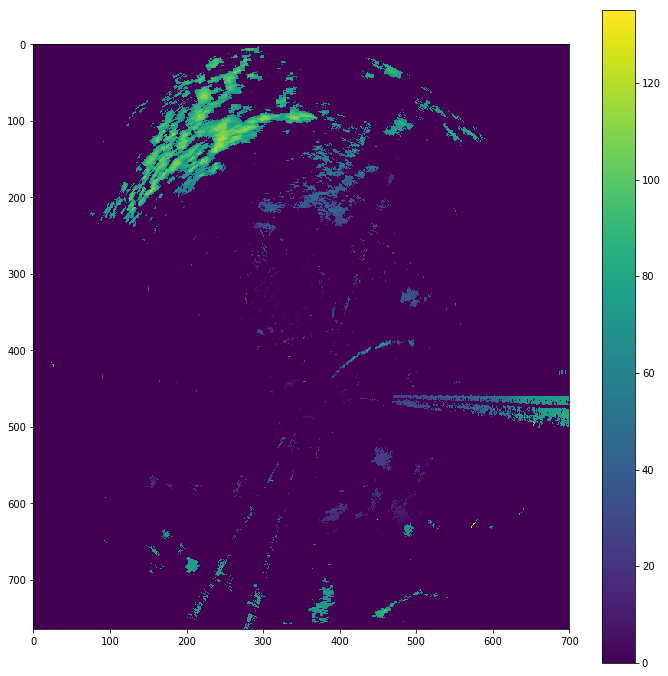

In [83]:
# numpy array offers more functionality than h5py dataset type
img = np.array(a['image1']['image_data'])
# Set NaN to 0 to increase color range when plotting
img[img==255] = 0
print("Min/max/mean:", img.min(), img.max(), img.mean())

%matplotlib inline
import matplotlib as mpl
from matplotlib import cm
fig = plt.figure(figsize=(12,12))
plt.imshow(img, cmap=cm.viridis)
plt.colorbar()